In [10]:
# Import required libraries
%pip install optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import optuna

# For models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Set constant seed for reproducibility
SEED = 42
np.random.seed(SEED)
# Remove optuna.seed(SEED) as it does not exist


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
# Downgrade numpy for TensorFlow compatibility (run this cell and restart kernel)
%pip install numpy==1.26.4


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
# Load dataset and select top 14 features
features = [
    'RiskScore', 'MonthlyCharges', 'AvgChargesPerMonth', 'ContractRisk', 'Contract',
    'TotalServices', 'TotalCharges', 'EstimatedCLV', 'HasFamily', 'tenure',
    'Partner', 'HighValueCustomer', 'PaymentRisk', 'Dependents'
]
df = pd.read_csv('final_telco_engineered.csv')
X = df[features]
# Assuming target column is 'Churn' (update if different)
y = df['Churn']

In [13]:
# Identify categorical and numerical columns for preprocessing
categorical_cols = ['Contract', 'HasFamily', 'Partner', 'HighValueCustomer', 'Dependents']
numerical_cols = [col for col in features if col not in categorical_cols]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

In [14]:
# Train/validation/test split (80/10/10)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=SEED, stratify=y_temp)
# 0.1111 * 0.90 ≈ 0.10

In [15]:
# Ensure target variable is numeric (0/1)
if y_train.dtype == 'O' or y_train.dtype.name == 'category':
    y_train = y_train.map({'No': 0, 'Yes': 1}).astype(int)
    y_val = y_val.map({'No': 0, 'Yes': 1}).astype(int)
    y_test = y_test.map({'No': 0, 'Yes': 1}).astype(int)

In [16]:
# Fit preprocessor on ORIGINAL training data (before oversampling)
# This ensures scaling parameters reflect true feature distribution
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

# Now apply random oversampling to balance classes 50/50 on PREPROCESSED training data
from sklearn.utils import resample

# Show class distribution before oversampling
print("Before oversampling:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts(normalize=True))

# Combine preprocessed X_train and y_train for resampling
_df_train = pd.DataFrame(X_train_proc)
_df_train['Churn'] = y_train.reset_index(drop=True)
_df_majority = _df_train[_df_train['Churn'] == 0]
_df_minority = _df_train[_df_train['Churn'] == 1]

# Upsample minority to match majority count
_df_minority_up = resample(
    _df_minority,
    replace=True,
    n_samples=len(_df_majority),
    random_state=SEED,
)

# Recombine and shuffle
_df_balanced = pd.concat([_df_majority, _df_minority_up], axis=0)
_df_balanced = _df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Split back into features/target
X_train_proc = _df_balanced.drop(columns=['Churn']).values
y_train = _df_balanced['Churn'].astype(int).values

print("\nAfter oversampling:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts(normalize=True))


Before oversampling:
Churn
0    4138
1    1495
Name: count, dtype: int64
Churn
0    0.7346
1    0.2654
Name: proportion, dtype: float64

After oversampling:
0    4138
1    4138
Name: count, dtype: int64
0    0.5
1    0.5
Name: proportion, dtype: float64



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[I 2025-11-12 20:22:14,459] A new study created in memory with name: no-name-3acd2725-28af-4b63-99e0-ae417fd14455
  0%|          | 0/20 [00:00<?, ?it/s]2025-11-12 20:22:14.488619: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-11-12 20:22:14.488672: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-12 20:22:14.488683: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-12 20:22:14.489056: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-12 20

[I 2025-11-12 20:22:30,203] Trial 0 finished with value: 0.15867280960083008 and parameters: {'n_units': 58, 'lr': 0.007969454818643935, 'dropout': 0.36599697090570255, 'batch_size': 90}. Best is trial 0 with value: 0.15867280960083008.


Best trial: 0. Best value: 0.158673:  10%|█         | 2/20 [00:58<09:27, 31.56s/it]

[I 2025-11-12 20:23:12,832] Trial 1 finished with value: 0.1603761911392212 and parameters: {'n_units': 33, 'lr': 0.00020511104188433984, 'dropout': 0.02904180608409973, 'batch_size': 116}. Best is trial 0 with value: 0.15867280960083008.


Best trial: 0. Best value: 0.158673:  15%|█▌        | 3/20 [01:12<06:39, 23.50s/it]

[I 2025-11-12 20:23:26,738] Trial 2 finished with value: 0.16074782609939575 and parameters: {'n_units': 83, 'lr': 0.0026070247583707684, 'dropout': 0.010292247147901223, 'batch_size': 126}. Best is trial 0 with value: 0.15867280960083008.


Best trial: 3. Best value: 0.158518:  20%|██        | 4/20 [01:58<08:41, 32.58s/it]

[I 2025-11-12 20:24:13,251] Trial 3 finished with value: 0.1585179567337036 and parameters: {'n_units': 110, 'lr': 0.00026587543983272726, 'dropout': 0.09091248360355031, 'batch_size': 49}. Best is trial 3 with value: 0.1585179567337036.


Best trial: 3. Best value: 0.158518:  25%|██▌       | 5/20 [02:28<07:51, 31.43s/it]

[I 2025-11-12 20:24:42,629] Trial 4 finished with value: 0.15916311740875244 and parameters: {'n_units': 50, 'lr': 0.0011207606211860567, 'dropout': 0.21597250932105788, 'batch_size': 60}. Best is trial 3 with value: 0.1585179567337036.


Best trial: 3. Best value: 0.158518:  30%|███       | 6/20 [03:27<09:30, 40.77s/it]

[I 2025-11-12 20:25:41,543] Trial 5 finished with value: 0.15989094972610474 and parameters: {'n_units': 85, 'lr': 0.00019010245319870352, 'dropout': 0.14607232426760908, 'batch_size': 67}. Best is trial 3 with value: 0.1585179567337036.


Best trial: 6. Best value: 0.158332:  35%|███▌      | 7/20 [03:48<07:26, 34.38s/it]

[I 2025-11-12 20:26:02,752] Trial 6 finished with value: 0.15833210945129395 and parameters: {'n_units': 67, 'lr': 0.0037183641805732083, 'dropout': 0.09983689107917987, 'batch_size': 81}. Best is trial 6 with value: 0.15833210945129395.


Best trial: 6. Best value: 0.158332:  40%|████      | 8/20 [05:25<10:51, 54.31s/it]

[I 2025-11-12 20:27:39,729] Trial 7 finished with value: 0.15878117084503174 and parameters: {'n_units': 82, 'lr': 0.0001238513729886094, 'dropout': 0.3037724259507192, 'batch_size': 48}. Best is trial 6 with value: 0.15833210945129395.


Best trial: 6. Best value: 0.158332:  45%|████▌     | 9/20 [05:48<08:10, 44.61s/it]

[I 2025-11-12 20:28:03,006] Trial 8 finished with value: 0.15872955322265625 and parameters: {'n_units': 23, 'lr': 0.007902619549708232, 'dropout': 0.4828160165372797, 'batch_size': 110}. Best is trial 6 with value: 0.15833210945129395.


Best trial: 6. Best value: 0.158332:  50%|█████     | 10/20 [07:09<09:18, 55.86s/it]

[I 2025-11-12 20:29:24,056] Trial 9 finished with value: 0.1611865758895874 and parameters: {'n_units': 50, 'lr': 0.0001567993391672301, 'dropout': 0.34211651325607845, 'batch_size': 74}. Best is trial 6 with value: 0.15833210945129395.


Best trial: 6. Best value: 0.158332:  55%|█████▌    | 11/20 [07:37<07:05, 47.30s/it]

[I 2025-11-12 20:29:51,951] Trial 10 finished with value: 0.15905994176864624 and parameters: {'n_units': 122, 'lr': 0.0025838500351805663, 'dropout': 0.1843643863605487, 'batch_size': 94}. Best is trial 6 with value: 0.15833210945129395.


Best trial: 6. Best value: 0.158332:  60%|██████    | 12/20 [09:40<09:22, 70.30s/it]

[I 2025-11-12 20:31:54,855] Trial 11 finished with value: 0.15841472148895264 and parameters: {'n_units': 115, 'lr': 0.0004872311972287137, 'dropout': 0.10645867707746028, 'batch_size': 33}. Best is trial 6 with value: 0.15833210945129395.


Best trial: 6. Best value: 0.158332:  65%|██████▌   | 13/20 [10:36<07:41, 65.86s/it]

[I 2025-11-12 20:32:50,513] Trial 12 finished with value: 0.1586160659790039 and parameters: {'n_units': 104, 'lr': 0.0005743921379695773, 'dropout': 0.10360557614964735, 'batch_size': 33}. Best is trial 6 with value: 0.15833210945129395.


Best trial: 13. Best value: 0.157842:  70%|███████   | 14/20 [11:16<05:49, 58.21s/it]

[I 2025-11-12 20:33:31,030] Trial 13 finished with value: 0.15784180164337158 and parameters: {'n_units': 67, 'lr': 0.0006611952874621073, 'dropout': 0.08915589553413503, 'batch_size': 88}. Best is trial 13 with value: 0.15784180164337158.


Best trial: 13. Best value: 0.157842:  75%|███████▌  | 15/20 [11:43<04:04, 48.82s/it]

[I 2025-11-12 20:33:58,110] Trial 14 finished with value: 0.1583734154701233 and parameters: {'n_units': 64, 'lr': 0.002032604737796689, 'dropout': 0.26239557160303995, 'batch_size': 87}. Best is trial 13 with value: 0.15784180164337158.


Best trial: 13. Best value: 0.157842:  80%|████████  | 16/20 [11:59<02:35, 38.81s/it]

[I 2025-11-12 20:34:13,669] Trial 15 finished with value: 0.15905994176864624 and parameters: {'n_units': 95, 'lr': 0.0045647651722983285, 'dropout': 0.05563638628093355, 'batch_size': 102}. Best is trial 13 with value: 0.15784180164337158.


Best trial: 13. Best value: 0.157842:  85%|████████▌ | 17/20 [12:24<01:44, 34.79s/it]

[I 2025-11-12 20:34:39,117] Trial 16 finished with value: 0.15877079963684082 and parameters: {'n_units': 73, 'lr': 0.0010740664122397298, 'dropout': 0.16545376030494807, 'batch_size': 80}. Best is trial 13 with value: 0.15784180164337158.


Best trial: 13. Best value: 0.157842:  90%|█████████ | 18/20 [13:11<01:17, 38.55s/it]

[I 2025-11-12 20:35:26,396] Trial 17 finished with value: 0.16012847423553467 and parameters: {'n_units': 39, 'lr': 0.0006163674916360632, 'dropout': 0.24577714879706844, 'batch_size': 100}. Best is trial 13 with value: 0.15784180164337158.


Best trial: 13. Best value: 0.157842:  95%|█████████▌| 19/20 [13:32<00:33, 33.19s/it]

[I 2025-11-12 20:35:47,121] Trial 18 finished with value: 0.1583837866783142 and parameters: {'n_units': 71, 'lr': 0.004176243459575295, 'dropout': 0.056404944069328854, 'batch_size': 76}. Best is trial 13 with value: 0.15784180164337158.


Best trial: 13. Best value: 0.157842: 100%|██████████| 20/20 [14:02<00:00, 42.10s/it]


[I 2025-11-12 20:36:16,543] Trial 19 finished with value: 0.16084074974060059 and parameters: {'n_units': 17, 'lr': 0.001543600270851366, 'dropout': 0.4270627421637062, 'batch_size': 63}. Best is trial 13 with value: 0.15784180164337158.
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
FNN Test Results:
Accuracy: 0.7404
F1 Score: 0.6164
Precision: 0.5069
Recall (Sensitivity): 0.7861
Specificity: 0.7239
AUC: 0.8396


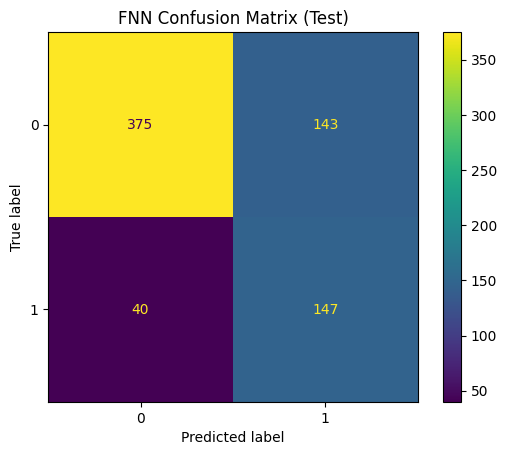

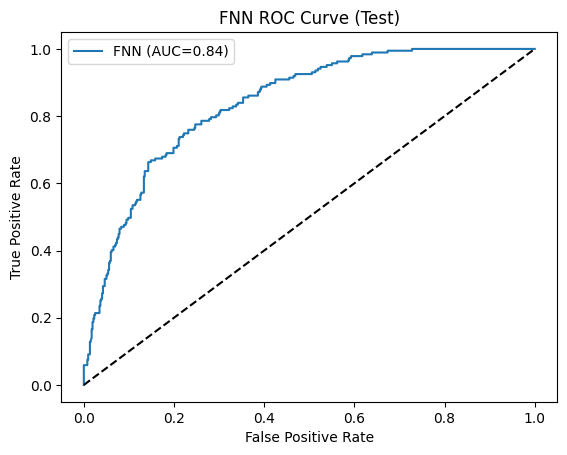

In [17]:
# Feed Forward Neural Network (FNN) with Optuna hyperparameter tuning
%pip install tensorflow-macos tensorflow-metal
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Note: Class weights removed in favor of random oversampling on training data above

def create_fnn_model(trial):
    n_units = trial.suggest_int('n_units', 16, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    model = models.Sequential([
        layers.Input(shape=(X_train_proc.shape[1],)),
        layers.Dense(n_units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy(), metrics=['accuracy', metrics.AUC(name='auc')])
    return model

def objective_fnn(trial):
    model = create_fnn_model(trial)
    early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
    history = model.fit(
        X_train_proc, y_train,
        validation_data=(X_val_proc, y_val),
        epochs=30,
        batch_size=trial.suggest_int('batch_size', 32, 128),
        verbose=0,
        callbacks=[early_stop]
    )
    val_auc = max(history.history.get('val_auc', [0]))
    return 1 - val_auc  # Optuna minimizes

study_fnn = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_fnn.optimize(objective_fnn, n_trials=20, show_progress_bar=True)

# Train best FNN model
best_params_fnn = study_fnn.best_params
best_fnn = create_fnn_model(optuna.trial.FixedTrial(best_params_fnn))
early_stop_final = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
best_fnn.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=30,
    batch_size=best_params_fnn['batch_size'],
    verbose=0,
    callbacks=[early_stop_final]
)
# Evaluate on test set
pred_test_fnn = best_fnn.predict(X_test_proc).ravel()
pred_test_label_fnn = (pred_test_fnn > 0.5).astype(int)
cm_fnn = confusion_matrix(y_test, pred_test_label_fnn)
roc_auc_fnn = roc_auc_score(y_test, pred_test_fnn)
f1_fnn = f1_score(y_test, pred_test_label_fnn)
precision_fnn = precision_score(y_test, pred_test_label_fnn)
recall_fnn = recall_score(y_test, pred_test_label_fnn)
specificity_fnn = cm_fnn[0,0] / (cm_fnn[0,0] + cm_fnn[0,1]) if (cm_fnn[0,0] + cm_fnn[0,1]) > 0 else 0
accuracy_fnn = (cm_fnn[0,0] + cm_fnn[1,1]) / cm_fnn.sum()

print('FNN Test Results:')
print(f'Accuracy: {accuracy_fnn:.4f}')
print(f'F1 Score: {f1_fnn:.4f}')
print(f'Precision: {precision_fnn:.4f}')
print(f'Recall (Sensitivity): {recall_fnn:.4f}')
print(f'Specificity: {specificity_fnn:.4f}')
print(f'AUC: {roc_auc_fnn:.4f}')

# Plot Confusion Matrix (Test)
ConfusionMatrixDisplay(cm_fnn).plot()
plt.title('FNN Confusion Matrix (Test)')
plt.show()

# Plot ROC Curve (Test)
fpr_fnn, tpr_fnn, _ = roc_curve(y_test, pred_test_fnn)
plt.figure()
plt.plot(fpr_fnn, tpr_fnn, label=f'FNN (AUC={roc_auc_fnn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FNN ROC Curve (Test)')
plt.legend()
plt.show()

[I 2025-11-12 20:36:48,850] A new study created in memory with name: no-name-71191cdf-7e39-47a4-9779-2f7785426435
Best trial: 0. Best value: 0.160015:   5%|▌         | 1/20 [00:38<12:13, 38.61s/it]

[I 2025-11-12 20:37:27,463] Trial 0 finished with value: 0.16001486778259277 and parameters: {'n_layers': 3, 'n_units': 124, 'lr': 0.0029106359131330704, 'dropout': 0.2993292420985183, 'batch_size': 47}. Best is trial 0 with value: 0.16001486778259277.


Best trial: 1. Best value: 0.158234:  10%|█         | 2/20 [01:20<12:13, 40.76s/it]

[I 2025-11-12 20:38:09,718] Trial 1 finished with value: 0.15823405981063843 and parameters: {'n_layers': 2, 'n_units': 37, 'lr': 0.005399484409787433, 'dropout': 0.3005575058716044, 'batch_size': 100}. Best is trial 1 with value: 0.15823405981063843.


Best trial: 1. Best value: 0.158234:  15%|█▌        | 3/20 [02:01<11:32, 40.74s/it]

[I 2025-11-12 20:38:50,430] Trial 2 finished with value: 0.15846633911132812 and parameters: {'n_layers': 2, 'n_units': 126, 'lr': 0.004622589001020831, 'dropout': 0.10616955533913808, 'batch_size': 49}. Best is trial 1 with value: 0.15823405981063843.


Best trial: 1. Best value: 0.158234:  20%|██        | 4/20 [02:24<08:57, 33.58s/it]

[I 2025-11-12 20:39:13,052] Trial 3 finished with value: 0.15891027450561523 and parameters: {'n_layers': 2, 'n_units': 61, 'lr': 0.0011207606211860567, 'dropout': 0.21597250932105788, 'batch_size': 60}. Best is trial 1 with value: 0.15823405981063843.


Best trial: 1. Best value: 0.158234:  25%|██▌       | 5/20 [02:48<07:35, 30.34s/it]

[I 2025-11-12 20:39:37,644] Trial 4 finished with value: 0.15933865308761597 and parameters: {'n_layers': 3, 'n_units': 45, 'lr': 0.0003839629299804173, 'dropout': 0.18318092164684585, 'batch_size': 76}. Best is trial 1 with value: 0.15823405981063843.


Best trial: 1. Best value: 0.158234:  30%|███       | 6/20 [04:21<11:59, 51.40s/it]

[I 2025-11-12 20:41:09,923] Trial 5 finished with value: 0.15927159786224365 and parameters: {'n_layers': 4, 'n_units': 51, 'lr': 0.0010677482709481358, 'dropout': 0.29620728443102123, 'batch_size': 36}. Best is trial 1 with value: 0.15823405981063843.


Best trial: 1. Best value: 0.158234:  35%|███▌      | 7/20 [05:04<10:35, 48.86s/it]

[I 2025-11-12 20:41:53,541] Trial 6 finished with value: 0.16508370637893677 and parameters: {'n_layers': 3, 'n_units': 48, 'lr': 0.00013492834268013249, 'dropout': 0.4744427686266666, 'batch_size': 125}. Best is trial 1 with value: 0.15823405981063843.


Best trial: 1. Best value: 0.158234:  40%|████      | 8/20 [05:45<09:13, 46.14s/it]

[I 2025-11-12 20:42:33,875] Trial 7 finished with value: 0.16604900360107422 and parameters: {'n_layers': 4, 'n_units': 61, 'lr': 0.0001567993391672301, 'dropout': 0.34211651325607845, 'batch_size': 74}. Best is trial 1 with value: 0.15823405981063843.


Best trial: 1. Best value: 0.158234:  45%|████▌     | 9/20 [06:59<10:05, 55.01s/it]

[I 2025-11-12 20:43:48,374] Trial 8 finished with value: 0.1616356372833252 and parameters: {'n_layers': 2, 'n_units': 80, 'lr': 0.00011715937392307068, 'dropout': 0.45466020103939103, 'batch_size': 57}. Best is trial 1 with value: 0.15823405981063843.


Best trial: 1. Best value: 0.158234:  50%|█████     | 10/20 [07:57<09:17, 55.79s/it]

[I 2025-11-12 20:44:45,904] Trial 9 finished with value: 0.1615995168685913 and parameters: {'n_layers': 3, 'n_units': 62, 'lr': 0.001096821720752952, 'dropout': 0.2733551396716398, 'batch_size': 49}. Best is trial 1 with value: 0.15823405981063843.


Best trial: 1. Best value: 0.158234:  55%|█████▌    | 11/20 [08:11<06:29, 43.28s/it]

[I 2025-11-12 20:45:00,840] Trial 10 finished with value: 0.15955030918121338 and parameters: {'n_layers': 2, 'n_units': 32, 'lr': 0.008691089486124988, 'dropout': 0.0089809378074098, 'batch_size': 112}. Best is trial 1 with value: 0.15823405981063843.


Best trial: 11. Best value: 0.157517:  60%|██████    | 12/20 [08:26<04:35, 34.49s/it]

[I 2025-11-12 20:45:15,229] Trial 11 finished with value: 0.15751659870147705 and parameters: {'n_layers': 2, 'n_units': 126, 'lr': 0.009147100105091165, 'dropout': 0.08991640864257222, 'batch_size': 101}. Best is trial 11 with value: 0.15751659870147705.


Best trial: 11. Best value: 0.157517:  65%|██████▌   | 13/20 [08:41<03:21, 28.73s/it]

[I 2025-11-12 20:45:30,705] Trial 12 finished with value: 0.16119694709777832 and parameters: {'n_layers': 2, 'n_units': 104, 'lr': 0.008857629556020707, 'dropout': 0.10764543544059728, 'batch_size': 98}. Best is trial 11 with value: 0.15751659870147705.


Best trial: 13. Best value: 0.156727:  70%|███████   | 14/20 [09:09<02:49, 28.28s/it]

[I 2025-11-12 20:45:57,950] Trial 13 finished with value: 0.15672683715820312 and parameters: {'n_layers': 2, 'n_units': 96, 'lr': 0.0034296673213264376, 'dropout': 0.39445206991491655, 'batch_size': 94}. Best is trial 13 with value: 0.15672683715820312.


Best trial: 13. Best value: 0.156727:  75%|███████▌  | 15/20 [09:32<02:13, 26.75s/it]

[I 2025-11-12 20:46:21,136] Trial 14 finished with value: 0.1599116325378418 and parameters: {'n_layers': 2, 'n_units': 108, 'lr': 0.002398622741211032, 'dropout': 0.3947385331597324, 'batch_size': 92}. Best is trial 13 with value: 0.15672683715820312.


Best trial: 13. Best value: 0.156727:  80%|████████  | 16/20 [09:48<01:34, 23.69s/it]

[I 2025-11-12 20:46:37,717] Trial 15 finished with value: 0.1680930256843567 and parameters: {'n_layers': 3, 'n_units': 96, 'lr': 0.0022270414378132127, 'dropout': 0.03923119248339044, 'batch_size': 86}. Best is trial 13 with value: 0.15672683715820312.


Best trial: 13. Best value: 0.156727:  85%|████████▌ | 17/20 [10:10<01:09, 23.12s/it]

[I 2025-11-12 20:46:59,504] Trial 16 finished with value: 0.15854895114898682 and parameters: {'n_layers': 2, 'n_units': 88, 'lr': 0.004841071075236132, 'dropout': 0.39469087129708835, 'batch_size': 110}. Best is trial 13 with value: 0.15672683715820312.


Best trial: 13. Best value: 0.156727:  90%|█████████ | 18/20 [10:29<00:43, 21.78s/it]

[I 2025-11-12 20:47:18,192] Trial 17 finished with value: 0.16127949953079224 and parameters: {'n_layers': 4, 'n_units': 117, 'lr': 0.0004044758550598607, 'dropout': 0.16159725389852392, 'batch_size': 128}. Best is trial 13 with value: 0.15672683715820312.


Best trial: 13. Best value: 0.156727:  95%|█████████▌| 19/20 [10:42<00:19, 19.19s/it]

[I 2025-11-12 20:47:31,326] Trial 18 finished with value: 0.1578933596611023 and parameters: {'n_layers': 2, 'n_units': 82, 'lr': 0.0037202084867109957, 'dropout': 0.08277814069268896, 'batch_size': 111}. Best is trial 13 with value: 0.15672683715820312.


Best trial: 13. Best value: 0.156727: 100%|██████████| 20/20 [11:21<00:00, 34.08s/it]


[I 2025-11-12 20:48:10,495] Trial 19 finished with value: 0.1607375144958496 and parameters: {'n_layers': 3, 'n_units': 112, 'lr': 0.001755746536816571, 'dropout': 0.4023868014400371, 'batch_size': 70}. Best is trial 13 with value: 0.15672683715820312.
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
MLP Test Results:
Accuracy: 0.7546
F1 Score: 0.6296
Precision: 0.5250
Recall (Sensitivity): 0.7861
Specificity: 0.7432
AUC: 0.8367


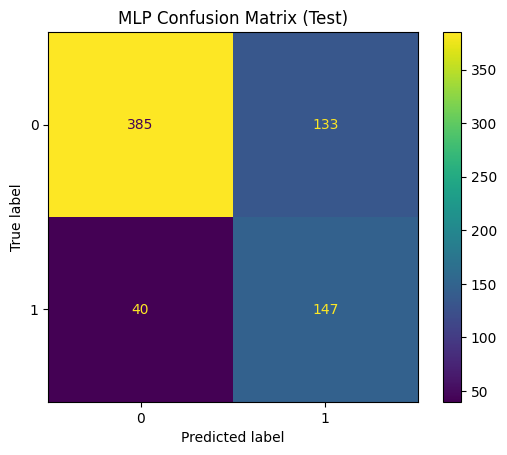

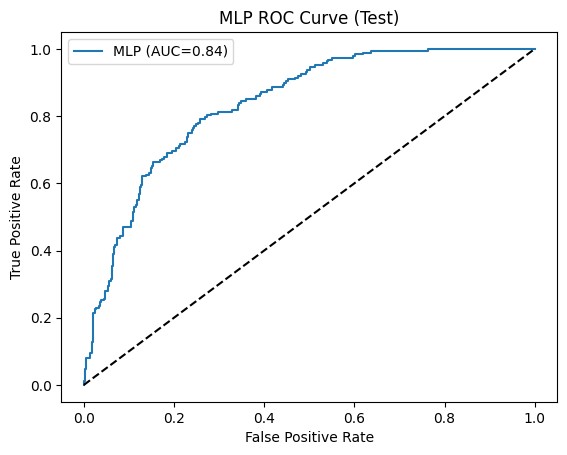

In [18]:
# Multi-Layer Perceptron (MLP) with Optuna hyperparameter tuning
from tensorflow.keras.callbacks import EarlyStopping

def create_mlp_model(trial):
    n_layers = trial.suggest_int('n_layers', 2, 4)
    n_units = trial.suggest_int('n_units', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train_proc.shape[1],)))
    for _ in range(n_layers):
        model.add(layers.Dense(n_units, activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy(), metrics=['accuracy', metrics.AUC(name='auc')])
    return model

def objective_mlp(trial):
    model = create_mlp_model(trial)
    early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
    history = model.fit(
        X_train_proc, y_train,
        validation_data=(X_val_proc, y_val),
        epochs=30,
        batch_size=trial.suggest_int('batch_size', 32, 128),
        verbose=0,
        callbacks=[early_stop]
    )
    val_auc = max(history.history.get('val_auc', [0]))
    return 1 - val_auc

study_mlp = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_mlp.optimize(objective_mlp, n_trials=20, show_progress_bar=True)

# Train best MLP model
best_params_mlp = study_mlp.best_params
best_mlp = create_mlp_model(optuna.trial.FixedTrial(best_params_mlp))
early_stop_final = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
best_mlp.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=30,
    batch_size=best_params_mlp['batch_size'],
    verbose=0,
    callbacks=[early_stop_final]
)
# Evaluate on test set
pred_test_mlp = best_mlp.predict(X_test_proc).ravel()
pred_test_label_mlp = (pred_test_mlp > 0.5).astype(int)
cm_mlp = confusion_matrix(y_test, pred_test_label_mlp)
roc_auc_mlp = roc_auc_score(y_test, pred_test_mlp)
f1_mlp = f1_score(y_test, pred_test_label_mlp)
precision_mlp = precision_score(y_test, pred_test_label_mlp)
recall_mlp = recall_score(y_test, pred_test_label_mlp)
specificity_mlp = cm_mlp[0,0] / (cm_mlp[0,0] + cm_mlp[0,1]) if (cm_mlp[0,0] + cm_mlp[0,1]) > 0 else 0
accuracy_mlp = (cm_mlp[0,0] + cm_mlp[1,1]) / cm_mlp.sum()

print('MLP Test Results:')
print(f'Accuracy: {accuracy_mlp:.4f}')
print(f'F1 Score: {f1_mlp:.4f}')
print(f'Precision: {precision_mlp:.4f}')
print(f'Recall (Sensitivity): {recall_mlp:.4f}')
print(f'Specificity: {specificity_mlp:.4f}')
print(f'AUC: {roc_auc_mlp:.4f}')

# Plot Confusion Matrix (Test)
ConfusionMatrixDisplay(cm_mlp).plot()
plt.title('MLP Confusion Matrix (Test)')
plt.show()

# Plot ROC Curve (Test)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, pred_test_mlp)
plt.figure()
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC={roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve (Test)')
plt.legend()
plt.show()